Creator: Yen Ting Lin, CCS-3, LANL 

Note: For the manuscript "*Gene expression noise accelerates the evolution of a biological oscillator*", co-authored by Nicolas E. Buchler, NCSU

The code has been reviewed by Richard P. Feynman Center for Innovation at the Los Alamos National Laboratory, with a C number C21109

This notebook simulates the evolutionary processes of two biophysical parameters $\beta^F_X$ and $\beta^B_X$ for stochastic gene expression dynamics.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from matplotlib import cm 

from multiprocessing import Pool
from subprocess import call, STDOUT

from scipy import signal
from scipy.stats import norm, uniform, multivariate_normal

In [2]:
plt.rcParams.update({'font.size':14})

In [3]:
initial2Dlocations = np.array([
    [9 , 165],
    [7 , 210],
    [6.5 , 260],
    [9 , 310],
    [20, 165],
    [20, 300],
    [25, 210],
    [25, 260],
])

In [4]:
mutationCovDiag = 0.01*np.array([1.0, 40])

In [5]:
rep = 1   # Replica index. For the paper, we ran 5 replica and made sure the observations are robust 
globalIndex = rep

In [6]:
populationN = 100
poolN = populationN

In [7]:
def visualizePopulationDistribution(parList):
    plt.hist(initialPar, bins=10)
    plt.xlabel('$r_0$')
    plt.ylabel('Histogram')

In [8]:
def run_model(par):
    
    lf = open('./evoBuffer/'+str(globalIndex*populationN+par[0])+'.log','w')
    parameters=f'{par[1]} {par[2]} 1000 50 0.005 {globalIndex*populationN+par[0]}'   # par[1]: betaFX, par[2]: betaBX, par[0]: unique ID
    call("./t_evolution.out %s"%parameters,shell=True,stdout=lf,stderr=STDOUT)
    lf.close()
    

In [9]:
def compileParList(par):
    
    populationN = len(par)
    
    parList = np.zeros((populationN, 3))
    
    parList[:,0] = range(populationN)
    parList[:,1:] = par[:,:]
    
    return parList

In [10]:
def batchRun(parList):
    
    pool = Pool(processes=poolN)
    pool.map(run_model,parList)
    pool.close()

In [11]:
def evaluatePeak(populationN):
    
    output = []
    
    output_fullPSD = []
    
    for i in range(populationN):
    
        data = np.genfromtxt('./evoBuffer/titrationOscillator-'+str(globalIndex*populationN+i)+'.txt')
        x=data[5000:,3]

        dt = data[1,0]-data[0,0]
        x=x-np.mean(x)
        fs = 1/dt
        freqTemp, psdTemp = signal.welch(x, fs, nperseg=256, nfft=len(x), window='boxcar', noverlap=0)

        maxDensity = np.amax(psdTemp)
        index = np.where(psdTemp==maxDensity)[0][0]
        maxFrequency = freqTemp[index]

        if maxDensity < 1E-4:
            
            maxDensity = 0    
            maxFrequency = 0
            
            
        output.append([maxFrequency, maxDensity])
        
        output_fullPSD.append(np.vstack((freqTemp, psdTemp)))

    return np.array(output),  np.array(output_fullPSD)

In [12]:
def evaluateFitness(parList):
    
    batchRun(parList)
    
    populationN = len(parList)
    l,_ = evaluatePeak(populationN)
    
    # combine peak frequency and peak power
    targetF = 1.5

    C0 = 0
    C1 = 1
    
    #return -C1*(l[:,0]-targetF)**2 + l[:,1]
    return l[:,1]/(1+l[:,1])/(1+(l[:,0]-targetF)**2)

In [13]:
def generate2DMutation(par,size):
   
    if len(par.shape)==1:
        
        # single parameter set
        
        return multivariate_normal(mean=par, cov=np.diag(mutationCovDiag)).rvs(size)
        
    elif len(par.shape)==2:
        
        NN,MM = par.shape
        output = np.zeros([size, MM])
        
        for i in range(size):
            
            output[i,:] = multivariate_normal(mean=par[np.random.choice(NN),:], cov=np.diag(mutationCovDiag)).rvs(1)
            
        return output

In [14]:
def selectionMutation(parList):
    
    populationN = len(parList)
    
    selectionPercentage = 10.
    
    selectedN = np.around(populationN*(selectionPercentage/100)).astype('int64')
    
    # Evaluate the fitness
    f = evaluateFitness(parList)

    # Order and select
    selectedIndex = f.argsort()[::-1][:selectedN]

    # select
    selectedPar = parList[selectedIndex,1:]
    
    # mutation kernel
    
    newParList = np.zeros((populationN, parList.shape[1]))

    newParList[:,0] = range(populationN)
    newParList[:,1:] = generate2DMutation(selectedPar,populationN)
    
    return newParList,f
    
    

In [15]:
# generate N paths
pathN = len(initial2Dlocations)

tN = 200

summary = np.zeros([1+initial2Dlocations.shape[1], pathN, tN, populationN])

ifContinue = False

if ifContinue:
    
    previousSummary = np.load('20210929-full2DevolutionLog-sto-correctedCov-rep'+str(rep)+'.npz')['summary']

    T = previousSummary.shape[2]
        
    summary = np.zeros([1+initial2Dlocations.shape[1], pathN, T+tN, populationN])
        

else:

    T = 0

        
for pp in range(pathN):

    if ifContinue:
        
        for i in range(T):
            
            summary[:,:,i,:] = previousSummary[:,:,i,:]
        
            initialPar = previousSummary[:-1,pp,-1,:].T
            
    else:
        
        initialPar = generate2DMutation(initial2Dlocations[pp,:],populationN)
    
    parList = compileParList(initialPar)
    
    for tt in range(T,T+tN):

        parList,fitness = selectionMutation(parList)
        
        summary[:-1, pp, tt, :] = parList[:,1:].T
        summary[-1, pp, tt, :] = fitness[:]
        
        print('Path='+str(pp)+', iteration '+ str(tt) + ', location=' + str(np.mean(parList[:,1:] ,axis=0)), flush=True)

Path=0, iteration 0, location=[  9.00343783 164.8293738 ]
Path=0, iteration 1, location=[  8.97734106 164.72318327]
Path=0, iteration 2, location=[  8.96489001 165.44168885]
Path=0, iteration 3, location=[  9.07765413 165.2474067 ]
Path=0, iteration 4, location=[  9.1237805  165.82156796]
Path=0, iteration 5, location=[  9.07804621 166.10382427]
Path=0, iteration 6, location=[  9.00685036 166.46739723]
Path=0, iteration 7, location=[  9.10802434 166.94926309]
Path=0, iteration 8, location=[  9.06532875 166.66441375]
Path=0, iteration 9, location=[  9.10446913 165.67795954]
Path=0, iteration 10, location=[  8.93372752 167.40740016]
Path=0, iteration 11, location=[  9.00391965 166.8690907 ]
Path=0, iteration 12, location=[  8.99110009 168.02216347]
Path=0, iteration 13, location=[  8.9640677  168.51188679]
Path=0, iteration 14, location=[  8.97604198 169.89353447]
Path=0, iteration 15, location=[  8.97826996 170.51669131]
Path=0, iteration 16, location=[  8.95621629 170.89816459]
Path=0,

Path=0, iteration 139, location=[ 12.6203955  179.53411198]
Path=0, iteration 140, location=[ 12.62224185 180.09150074]
Path=0, iteration 141, location=[ 12.69442408 181.28691202]
Path=0, iteration 142, location=[ 12.79485148 182.89805842]
Path=0, iteration 143, location=[ 13.0426566  183.01096347]
Path=0, iteration 144, location=[ 13.13623752 183.53908854]
Path=0, iteration 145, location=[ 13.1482705  183.83124523]
Path=0, iteration 146, location=[ 13.29496991 184.35829801]
Path=0, iteration 147, location=[ 13.33421767 185.04458951]
Path=0, iteration 148, location=[ 13.34961346 185.63263194]
Path=0, iteration 149, location=[ 13.4930052  185.22901254]
Path=0, iteration 150, location=[ 13.48292674 186.86260663]
Path=0, iteration 151, location=[ 13.55054105 187.20375485]
Path=0, iteration 152, location=[ 13.77391145 187.47236197]
Path=0, iteration 153, location=[ 13.88303205 187.71649009]
Path=0, iteration 154, location=[ 14.01924074 188.27921851]
Path=0, iteration 155, location=[ 14.007

Path=1, iteration 79, location=[  7.53835003 223.35108425]
Path=1, iteration 80, location=[  7.66936288 222.96804435]
Path=1, iteration 81, location=[  7.7372471 222.6432917]
Path=1, iteration 82, location=[  7.65444306 222.3685755 ]
Path=1, iteration 83, location=[  7.66481405 221.85909918]
Path=1, iteration 84, location=[  7.63691793 221.5292695 ]
Path=1, iteration 85, location=[  7.61472427 220.0071757 ]
Path=1, iteration 86, location=[  7.61825215 220.99413797]
Path=1, iteration 87, location=[  7.58768195 220.8472147 ]
Path=1, iteration 88, location=[  7.60271921 221.4259439 ]
Path=1, iteration 89, location=[  7.65213015 221.4225356 ]
Path=1, iteration 90, location=[  7.61340608 218.79125404]
Path=1, iteration 91, location=[  7.59533708 217.82592078]
Path=1, iteration 92, location=[  7.66474814 217.72609006]
Path=1, iteration 93, location=[  7.74679142 217.73802076]
Path=1, iteration 94, location=[  7.6241544  218.24761266]
Path=1, iteration 95, location=[  7.72420909 218.08101308]

Path=2, iteration 17, location=[  6.66574482 262.92736715]
Path=2, iteration 18, location=[  6.61821979 262.57625583]
Path=2, iteration 19, location=[  6.50874508 263.14629007]
Path=2, iteration 20, location=[  6.49475639 264.75071269]
Path=2, iteration 21, location=[  6.50031219 264.97921451]
Path=2, iteration 22, location=[  6.45983814 264.65413145]
Path=2, iteration 23, location=[  6.38051459 264.7078013 ]
Path=2, iteration 24, location=[  6.41332779 264.41881971]
Path=2, iteration 25, location=[  6.43695041 263.20192606]
Path=2, iteration 26, location=[  6.59707559 261.1237978 ]
Path=2, iteration 27, location=[  6.51975823 261.02537776]
Path=2, iteration 28, location=[  6.50227382 262.14143092]
Path=2, iteration 29, location=[  6.50854251 262.52302492]
Path=2, iteration 30, location=[  6.73744989 261.92409237]
Path=2, iteration 31, location=[  6.81854832 261.08059671]
Path=2, iteration 32, location=[  6.74360947 261.67676114]
Path=2, iteration 33, location=[  6.71824331 261.7647997

Path=2, iteration 155, location=[  6.78435478 253.09156695]
Path=2, iteration 156, location=[  6.76357532 253.39325152]
Path=2, iteration 157, location=[  6.8274613  253.67255273]
Path=2, iteration 158, location=[  6.83538371 254.0865602 ]
Path=2, iteration 159, location=[  6.73547841 253.32751458]
Path=2, iteration 160, location=[  6.76827599 252.56058367]
Path=2, iteration 161, location=[  6.81755166 252.93577091]
Path=2, iteration 162, location=[  6.91575093 251.82512332]
Path=2, iteration 163, location=[  6.92279156 251.89189355]
Path=2, iteration 164, location=[  7.09549971 251.11947045]
Path=2, iteration 165, location=[  7.05733178 251.19210224]
Path=2, iteration 166, location=[  7.11904783 250.65741451]
Path=2, iteration 167, location=[  7.19881139 250.3141874 ]
Path=2, iteration 168, location=[  7.32567382 249.77743103]
Path=2, iteration 169, location=[  7.42369646 248.8675756 ]
Path=2, iteration 170, location=[  7.41792805 247.93176205]
Path=2, iteration 171, location=[  7.332

Path=3, iteration 95, location=[ 12.49931499 281.52925896]
Path=3, iteration 96, location=[ 12.51311817 282.1573187 ]
Path=3, iteration 97, location=[ 12.5646368  282.02480556]
Path=3, iteration 98, location=[ 12.57332257 281.45841719]
Path=3, iteration 99, location=[ 12.76804231 280.40189467]
Path=3, iteration 100, location=[ 12.9511587  280.12411301]
Path=3, iteration 101, location=[ 12.90574858 280.37937533]
Path=3, iteration 102, location=[ 12.8219943 281.0580141]
Path=3, iteration 103, location=[ 12.95307398 279.64321513]
Path=3, iteration 104, location=[ 13.15515131 277.8868764 ]
Path=3, iteration 105, location=[ 13.13091263 277.01960471]
Path=3, iteration 106, location=[ 13.07085821 276.59265199]
Path=3, iteration 107, location=[ 13.01982848 276.10074019]
Path=3, iteration 108, location=[ 13.06491822 275.99349474]
Path=3, iteration 109, location=[ 13.06978007 275.57695569]
Path=3, iteration 110, location=[ 13.11539882 275.72810609]
Path=3, iteration 111, location=[ 13.16769478 2

Path=4, iteration 33, location=[ 17.15565696 181.66771421]
Path=4, iteration 34, location=[ 17.1067452 182.0393203]
Path=4, iteration 35, location=[ 17.1270763  182.98332124]
Path=4, iteration 36, location=[ 17.10803212 184.19275658]
Path=4, iteration 37, location=[ 17.07700447 184.68011454]
Path=4, iteration 38, location=[ 16.91142838 185.98175797]
Path=4, iteration 39, location=[ 16.83228415 186.65708147]
Path=4, iteration 40, location=[ 16.67733369 187.88870537]
Path=4, iteration 41, location=[ 16.60491595 188.35385857]
Path=4, iteration 42, location=[ 16.62948923 188.91840118]
Path=4, iteration 43, location=[ 16.45248197 189.28768822]
Path=4, iteration 44, location=[ 16.31684736 189.96910574]
Path=4, iteration 45, location=[ 16.19666118 190.68179463]
Path=4, iteration 46, location=[ 16.10901119 190.67419021]
Path=4, iteration 47, location=[ 15.99102123 191.1298017 ]
Path=4, iteration 48, location=[ 15.98905544 191.48391077]
Path=4, iteration 49, location=[ 15.90102366 191.53535882]

Path=4, iteration 171, location=[ 14.78560136 259.48519053]
Path=4, iteration 172, location=[ 14.80835839 259.57939962]
Path=4, iteration 173, location=[ 14.70207763 259.88056682]
Path=4, iteration 174, location=[ 14.69585076 259.03761811]
Path=4, iteration 175, location=[ 14.68417333 258.98072951]
Path=4, iteration 176, location=[ 14.68343223 259.12406021]
Path=4, iteration 177, location=[ 14.62586034 259.70933456]
Path=4, iteration 178, location=[ 14.6234433  258.86036864]
Path=4, iteration 179, location=[ 14.64972069 258.04355967]
Path=4, iteration 180, location=[ 14.59065704 259.36112583]
Path=4, iteration 181, location=[ 14.58645661 259.64813742]
Path=4, iteration 182, location=[ 14.52144265 259.38703869]
Path=4, iteration 183, location=[ 14.57484091 259.51822175]
Path=4, iteration 184, location=[ 14.51784764 258.67210899]
Path=4, iteration 185, location=[ 14.5864332  259.18468481]
Path=4, iteration 186, location=[ 14.65124843 260.53161487]
Path=4, iteration 187, location=[ 14.683

Path=5, iteration 110, location=[ 14.48276554 261.57981277]
Path=5, iteration 111, location=[ 14.48065334 261.43727512]
Path=5, iteration 112, location=[ 14.55574092 261.1439396 ]
Path=5, iteration 113, location=[ 14.51124327 261.05419217]
Path=5, iteration 114, location=[ 14.62801143 261.03393002]
Path=5, iteration 115, location=[ 14.62257821 260.74463603]
Path=5, iteration 116, location=[ 14.61907362 260.62975662]
Path=5, iteration 117, location=[ 14.54174573 260.61851009]
Path=5, iteration 118, location=[ 14.56611684 260.05078676]
Path=5, iteration 119, location=[ 14.6500224  260.05951077]
Path=5, iteration 120, location=[ 14.6841399  259.52976369]
Path=5, iteration 121, location=[ 14.73535658 259.84092349]
Path=5, iteration 122, location=[ 14.67674097 260.36928449]
Path=5, iteration 123, location=[ 14.65422575 259.81160298]
Path=5, iteration 124, location=[ 14.65960938 259.37128007]
Path=5, iteration 125, location=[ 14.71233849 259.39288247]
Path=5, iteration 126, location=[ 14.743

Path=6, iteration 49, location=[ 21.2467991  213.57607005]
Path=6, iteration 50, location=[ 21.20406653 214.352641  ]
Path=6, iteration 51, location=[ 20.99462628 213.55315474]
Path=6, iteration 52, location=[ 20.85647321 213.28891186]
Path=6, iteration 53, location=[ 20.75075603 212.47659935]
Path=6, iteration 54, location=[ 20.66963039 213.21494655]
Path=6, iteration 55, location=[ 20.6060145  213.83759061]
Path=6, iteration 56, location=[ 20.49054316 213.96870909]
Path=6, iteration 57, location=[ 20.37095687 214.02380431]
Path=6, iteration 58, location=[ 20.16649043 213.70451776]
Path=6, iteration 59, location=[ 19.90473111 213.28654951]
Path=6, iteration 60, location=[ 19.74655917 213.24608259]
Path=6, iteration 61, location=[ 19.63956141 213.72609568]
Path=6, iteration 62, location=[ 19.59029374 213.92093961]
Path=6, iteration 63, location=[ 19.46304469 213.48074334]
Path=6, iteration 64, location=[ 19.33512721 213.43547571]
Path=6, iteration 65, location=[ 19.23390969 213.1005509

Path=6, iteration 187, location=[ 14.54039351 259.41691622]
Path=6, iteration 188, location=[ 14.54664756 258.71196719]
Path=6, iteration 189, location=[ 14.48401212 258.62106871]
Path=6, iteration 190, location=[ 14.54362473 259.53393626]
Path=6, iteration 191, location=[ 14.51254253 259.20896526]
Path=6, iteration 192, location=[ 14.58178821 259.6065505 ]
Path=6, iteration 193, location=[ 14.6127996  259.16198374]
Path=6, iteration 194, location=[ 14.59667177 259.5635598 ]
Path=6, iteration 195, location=[ 14.51958255 259.61082242]
Path=6, iteration 196, location=[ 14.52218975 259.62561451]
Path=6, iteration 197, location=[ 14.45655374 259.87554655]
Path=6, iteration 198, location=[ 14.3836544  260.28811547]
Path=6, iteration 199, location=[ 14.27344035 260.62489073]
Path=7, iteration 0, location=[ 24.96480948 259.87601959]
Path=7, iteration 1, location=[ 25.01119054 260.1214134 ]
Path=7, iteration 2, location=[ 25.02914731 260.19961624]
Path=7, iteration 3, location=[ 24.96635972 25

Path=7, iteration 126, location=[ 16.37487558 252.37405684]
Path=7, iteration 127, location=[ 16.27798648 252.11113048]
Path=7, iteration 128, location=[ 16.14589117 251.80977683]
Path=7, iteration 129, location=[ 15.91520929 252.22226735]
Path=7, iteration 130, location=[ 15.87962279 252.986838  ]
Path=7, iteration 131, location=[ 15.76496848 253.02335752]
Path=7, iteration 132, location=[ 15.71872516 253.11346544]
Path=7, iteration 133, location=[ 15.54260151 252.95532663]
Path=7, iteration 134, location=[ 15.44512538 252.50532272]
Path=7, iteration 135, location=[ 15.30298277 252.97634564]
Path=7, iteration 136, location=[ 15.23346306 253.13056499]
Path=7, iteration 137, location=[ 15.14242784 253.2984141 ]
Path=7, iteration 138, location=[ 15.08547948 253.16973857]
Path=7, iteration 139, location=[ 15.04851156 253.65814903]
Path=7, iteration 140, location=[ 15.15824987 252.92354412]
Path=7, iteration 141, location=[ 14.91936507 254.74321999]
Path=7, iteration 142, location=[ 14.857

# Save

In [16]:
np.savez('20210929-full2DevolutionLog-sto-correctedCov-rep'+str(rep), summary=summary)

# Visualize

In [17]:
dimFX = 301
dimBX = 301

betaFXgrid = np.linspace(5, 30, 301)
betaBXgrid = np.linspace(150, 320, 301)

betaBXgrid,betaFXgrid = np.meshgrid(betaBXgrid,betaFXgrid)

dataSto = np.load('stoLandscape.npz', allow_pickle=True)['fullOutput']
dataDet = np.load('detLandscape.npz', allow_pickle=True)['fullOutput']

betaFXmin = np.amin(dataSto[:,0])
betaFXmax = np.amax(dataSto[:,0])
betaBXmin = np.amin(dataSto[:,1])
betaBXmax = np.amax(dataSto[:,1])

PSDsto = np.reshape(dataSto[:,-1], [dimFX,dimBX])
PSDdet = np.reshape(dataDet[:,-1], [dimFX,dimBX])

Text(0, 0.5, '$\\beta^F_X$')

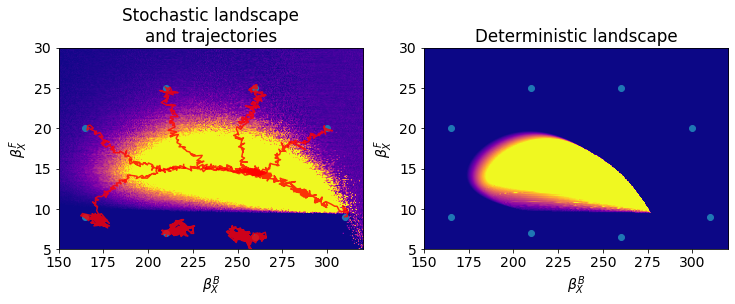

In [19]:
fig = plt.figure(figsize=(12, 5))

ax = [plt.subplot(1,2,i+1) for i in range(2)]

im = ['','']
im[0] = ax[0].imshow(PSDsto, extent=[betaBXmin, betaBXmax, betaFXmin, betaFXmax,], origin='lower', cmap=cm.plasma, aspect=4.5, vmax=0.025)
im[1] = ax[1].imshow(PSDdet, extent=[betaBXmin, betaBXmax, betaFXmin, betaFXmax,], origin='lower', cmap=cm.plasma, aspect=4.5, vmax=0.025)

ax[0].scatter(initial2Dlocations[:,1], initial2Dlocations[:,0])
ax[1].scatter(initial2Dlocations[:,1], initial2Dlocations[:,0])

for i in range(initial2Dlocations.shape[0]):
    
    ax[0].plot( summary[1, i, :, 1], summary[0, i, :, 1], color='r', alpha=0.8)
    
ax[0].set_xlim([betaBXmin, betaBXmax])
ax[0].set_ylim([betaFXmin, betaFXmax])

ax[0].set_title('Stochastic landscape\nand trajectories')
ax[1].set_title('Deterministic landscape')

ax[0].set_xlabel('$\\beta^B_X$')
ax[0].set_ylabel('$\\beta^F_X$')

ax[1].set_xlabel('$\\beta^B_X$')
ax[1].set_ylabel('$\\beta^F_X$')
